# 基于Koopman理论的全球中期天气预报

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/zh_cn/medium-range/mindspore_vit_kno.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/zh_cn/medium-range/mindspore_vit_kno.py)&emsp;[![ViewSource](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindearth/docs/source_zh_cn/medium-range/vit_kno.ipynb)

## 概述

现代数据天气预报(Numerical Weather Prediction, NWP)可以追溯到1920年，其基于物理原理，整合了几代气象学者的成果经验，是各国气象部门所采用主流的天气预报方法。其中来自欧洲中期天气预报中心(ECMWF)的高分辨率综合系统模型(IFS)表现效果最佳。

直到2022年英伟达研发了一种基于傅里叶神经网络的预测模型FourCastNet，它能以0.25°的分辨率生成全球关键天气指标的预测，这相当于赤道附近约30×30km的空间分辨率和720×1440像素的权重网格大小，与IFS系统一致。这项成果使得AI气象模型首次与传统的物理模型IFS进行直接比较。更多信息可参考：["FourCastNet: A Global Data-driven High-resolution Weather Model using Adaptive Fourier Neural Operators"](https://arxiv.org/pdf/2202.11214.pdf)。

但是基于傅里叶神经算子(Fourier Neural Operator, FNO)构建的预测模型FourCastNet在预测中长期天气时，变得不够准确和缺乏可解释性。ViT-KNO充分利用Vision Transformer结构和Koopman理论，学习Koopman Operator去预测非线性动力学系统，通过在线性结构中嵌入复杂的动力学去约束重建过程，ViT-KNO能够捕获复杂的非线性行为，同时保持模型轻量级和计算有效性。ViT-KNO有清晰的数学理论支撑，很好的克服了同类方法在数学和物理上可解释性和理论依据不足的问题。更多信息可参考：["KoopmanLab: machine learning for solving complex physics equations"](https://arxiv.org/pdf/2301.01104.pdf)。

## 技术路径

MindSpore求解该问题的具体流程如下：

1. 创建数据集
2. 模型构建
3. 损失函数
4. 模型训练
5. 模型验证和可视化

## ViT-KNO

ViT-KNO模型构架如下图所示，主要包含两个分支，上路分支负责结果预测，由Encoder模块，Koopman Layer模块，Decoder模块组成，其中Koopman Layer模块结构如虚线框所示，可重复堆叠；下路分支由Encoder模块，Decoder模块组成，负责输入信息的重构。

![ViT-KNO](./images/vit_kno.png "Model")

模型的训练流程如下：

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from mindspore import context, Model
from mindspore import dtype as mstype
from mindspore.train import load_checkpoint, load_param_into_net
from mindspore.train import DynamicLossScaleManager

from mindearth.cell import ViTKNO
from mindearth.utils import load_yaml_config, create_logger, plt_global_field_data, make_dir
from mindearth.data import Dataset, Era5Data, SIZE_DICT
from mindearth.module import Trainer

[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:45:25.165.000 [mindspore/run_check/_check_version.py:348] Using custom Ascend AI software package (Ascend Data Center Solution) path, package version checking is skipped. Please make sure Ascend AI software package (Ascend Data Center Solution) version is supported. For details, refer to the installation guidelines https://www.mindspore.cn/install
[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:45:25.167.000 [mindspore/run_check/_check_version.py:462] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:45:25.168.000 [mindspore/run_check/_check_version.py:469] Can not find driver so(need by mindspore-ascend). Please check whether the Environment Variable LD_LIBRARY_PATH is set. For 

 `src` 文件可以从[ViT-KNO/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/medium-range/koopman_vit/src)下载。

In [3]:
from src.callback import EvaluateCallBack, InferenceModule, Lploss, CustomWithLossCell

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)

[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:47:20.944.000 [mindspore/run_check/_check_version.py:348] Using custom Ascend AI software package (Ascend Data Center Solution) path, package version checking is skipped. Please make sure Ascend AI software package (Ascend Data Center Solution) version is supported. For details, refer to the installation guidelines https://www.mindspore.cn/install
[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:47:20.945.000 [mindspore/run_check/_check_version.py:462] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:47:20.946.000 [mindspore/run_check/_check_version.py:469] Can not find driver so(need by mindspore-ascend). Please check whether the Environment Variable LD_LIBRARY_PATH is set. For 

model、data和optimizer的参数可以通过加载yaml文件获取（[vit_kno.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/koopman_vit/configs/vit_kno_1.4.yaml)）。

In [ ]:
config = load_yaml_config('./configs/vit_kno_1.4.yaml')
config['model']['data_sink'] = True  # 是否使用data sink特性

config['train']['distribute'] = False  # 是否执行分布式任务
config['train']['amp_level'] = 'O2'  # 设置混合精度等级

config['data']['num_workers'] = 1  # 设置并行计算的进程数量
config['data']['h_size'], config['data']['w_size'] = SIZE_DICT[1.4]  # 设置气象分辨率参数

config['optimizer']['epochs'] = 100  # 设置epoch数量
config['optimizer']['finetune_epochs'] = 1  # 设置微调epoch数量
config['optimizer']['warmup_epochs'] = 1  # 设置预热epoch的数量
config['optimizer']['initial_lr'] = 0.0001  # 设置初始化学习率

config['summary']["valid_frequency"] = 10  # 设置验证的频率
config['summary']["summary_dir"] = './summary'  # 设置模型checkpoint的存储路径
make_dir(os.path.join(config['summary']["summary_dir"], "image"))
logger = create_logger(path=os.path.join(config['summary']["summary_dir"], "results.log"))

## 创建数据集

在[dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/WeatherBench_1.4_69/)路径下，下载正则化参数、训练数据集验证数据集到 `./dataset`目录。

修改[vit_kno.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/koopman_vit/configs/vit_kno_1.4.yaml)配置文件中的`root_dir`参数，该参数设置了数据集的路径。

`./dataset`中的目录结构如下所示：

``` markdown
.
├── statistic
│   ├── mean.npy
│   ├── mean_s.npy
│   ├── std.npy
│   └── std_s.npy
├── train
│   └── 2015
├── train_static
│   └── 2015
├── train_surface
│   └── 2015
├── train_surface_static
│   └── 2015
├── valid
│   └── 2016
├── valid_static
│   └── 2016
├── valid_surface
│   └── 2016
├── valid_surface_static
│   └── 2016
```


## 模型构建

加载相关的数据参数和模型参数，并完成ViT-KNO模型构建。

In [5]:
data_params = config["data"]
model_params = config["model"]
compute_type = mstype.float32

model = ViTKNO(image_size=(data_params["h_size"], data_params["w_size"]),
               in_channels=data_params["feature_dims"],
               out_channels=data_params["feature_dims"],
               patch_size=data_params["patch_size"],
               encoder_depths=model_params["encoder_depth"],
               encoder_embed_dims=model_params["encoder_embed_dim"],
               mlp_ratio=model_params["mlp_ratio"],
               dropout_rate=model_params["dropout_rate"],
               num_blocks=model_params["num_blocks"],
               high_freq=True,
               encoder_network=model_params["encoder_network"],
               compute_dtype=compute_type)

[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:47:41.325.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:47:41.603.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:47:42.334.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:47:42.396.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(334607:281473842241568,MainProcess):2024-11-28-11:47:42.458.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(334607:28147

## 损失函数

ViT-KNO使用多loss的训练方法，包括Prediction loss，Reconstruction loss，两者均基于均方误差（Mean Squared Error）。

In [7]:
loss_fn = Lploss()
loss_net = CustomWithLossCell(model, loss_fn)

## 模型训练

模型训练阶段继承了Trainer类，同时重写了get_dataset，get_callback，get_solver三个成员函数，以便于能在训练阶段执行测试验证；

In [8]:
class ViTKNOEra5Data(Era5Data):
    def _patch(self, *args):
        """ Partition the data into patches. """
        x = args[0]
        if self.run_mode == 'valid' or self.run_mode == 'test':
            x = x.transpose(1, 0, 2, 3)
        return x

class ViTKNOTrainer(Trainer):
    r"""
    Self-defined forecast model inherited from `Trainer`.

    Args:
        config (dict): parameters for training.
        model (Cell): network for training.
        loss_fn (str): user-defined loss function.
        logger (logging.RootLogger): tools for logging.

    Supported Platforms:
        ``Ascend`` ``GPU``

    """
    def __init__(self, config, model, loss_fn, logger):
        super(ViTKNOTrainer, self).__init__(config, model, loss_fn, logger)
        self.pred_cb = self.get_callback()

    def get_data_generator(self):
        """
        Get train and valid dataset.

        Returns:
            Dataset, train dataset.
            Dataset, valid dataset.
        """
        train_dataset_generator = ViTKNOEra5Data(data_params=self.data_params, run_mode='train')
        valid_dataset_generator = Era5Data(data_params=self.data_params, run_mode='valid')
        return train_dataset_generator, valid_dataset_generator

    def get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset_generator, self.config, self.logger)
        return pred_cb

    def get_solver(self):
        loss_scale = DynamicLossScaleManager()
        solver = Model(self.loss_fn,
                       optimizer=self.optimizer,
                       loss_scale_manager=loss_scale,
                       amp_level=self.train_params['amp_level']
                       )
        return solver


trainer = ViTKNOTrainer(config, model, loss_net, logger)


2024-11-28 11:49:43,899 - pretrain.py[line:229] - INFO: steps_per_epoch: 404


## 模型训练

[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-09:56:27.792.000 [mindspore/train/model.py:1328] For EvaluateCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-09:56:28.223.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-09:56:28.225.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-09:56:28.226.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-09:56:28.227.000 [mindspore/nn/layer/basic.py:203] For Dropout,

epoch: 1 step: 404, loss is 0.378
Train epoch time: 256871.791 ms, per step time: 635.821 ms
epoch: 2 step: 404, loss is 0.2996
Train epoch time: 100871.410 ms, per step time: 249.682 ms
epoch: 3 step: 404, loss is 0.288
Train epoch time: 95414.584 ms, per step time: 236.175 ms
epoch: 4 step: 404, loss is 0.2603
Train epoch time: 92897.653 ms, per step time: 229.945 ms
epoch: 5 step: 404, loss is 0.2573
Train epoch time: 92460.980 ms, per step time: 228.864 ms
epoch: 6 step: 404, loss is 0.2573
Train epoch time: 89571.894 ms, per step time: 221.713 ms
epoch: 7 step: 404, loss is 0.2441
Train epoch time: 92703.881 ms, per step time: 229.465 ms
epoch: 8 step: 404, loss is 0.2496
Train epoch time: 91673.309 ms, per step time: 226.914 ms
epoch: 9 step: 404, loss is 0.2482
Train epoch time: 95557.849 ms, per step time: 236.529 ms
epoch: 10 step: 404, loss is 0.2369
Train epoch time: 95264.542 ms, per step time: 235.803 ms


2024-11-28 10:14:51,092 - forecast.py[line:221] - INFO: ================================Start Evaluation================================
2024-11-28 10:14:51,094 - forecast.py[line:222] - INFO: test dataset size: 9
[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-10:14:51.539.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-10:14:51.540.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-10:14:51.542.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(239531:281473652465696,MainProcess):2024-11-28-10:14:51.543.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNI

PREDICTION TIME: 51.56370568275452 s
COMPUTE RMSE AND ACC TIME: 0.27927207946777344 s
PREDICTION TIME: 1.5737707614898682 s
COMPUTE RMSE AND ACC TIME: 0.2691943645477295 s
PREDICTION TIME: 1.5738637447357178 s
COMPUTE RMSE AND ACC TIME: 0.2631967067718506 s
PREDICTION TIME: 1.706406593322754 s
COMPUTE RMSE AND ACC TIME: 0.21641135215759277 s
PREDICTION TIME: 1.5047414302825928 s
COMPUTE RMSE AND ACC TIME: 0.23650527000427246 s
PREDICTION TIME: 1.4983727931976318 s
COMPUTE RMSE AND ACC TIME: 0.2208571434020996 s
PREDICTION TIME: 1.62650465965271 s
COMPUTE RMSE AND ACC TIME: 0.19023633003234863 s
PREDICTION TIME: 1.6195282936096191 s
COMPUTE RMSE AND ACC TIME: 0.2380819320678711 s
PREDICTION TIME: 1.6277599334716797 s


2024-11-28 10:16:01,501 - forecast.py[line:327] - INFO: t = 6 hour: 
2024-11-28 10:16:01,503 - forecast.py[line:329] - INFO:  RMSE of Z500: 299.66203853909303, T2m: 3.43716267548999, T850: 2.0444184330727597, U10: 1.8460172731241704
2024-11-28 10:16:01,503 - forecast.py[line:333] - INFO:  ACC  of Z500: 0.9771899743546, T2m: 0.9346742037846157, T850: 0.9414381379477279, U10: 0.9500246488797006
2024-11-28 10:16:01,504 - forecast.py[line:327] - INFO: t = 72 hour: 
2024-11-28 10:16:01,505 - forecast.py[line:329] - INFO:  RMSE of Z500: 932.6466665070725, T2m: 4.67628854798724, T850: 4.107470253031376, U10: 4.710497828252981
2024-11-28 10:16:01,506 - forecast.py[line:333] - INFO:  ACC  of Z500: 0.7907591621258848, T2m: 0.8738645755017767, T850: 0.7416699856234991, U10: 0.62682303766041
2024-11-28 10:16:01,507 - forecast.py[line:327] - INFO: t = 120 hour: 
2024-11-28 10:16:01,508 - forecast.py[line:329] - INFO:  RMSE of Z500: 1296.9758519695638, T2m: 5.366643256056041, T850: 4.714229220569383

COMPUTE RMSE AND ACC TIME: 0.2487804889678955 s


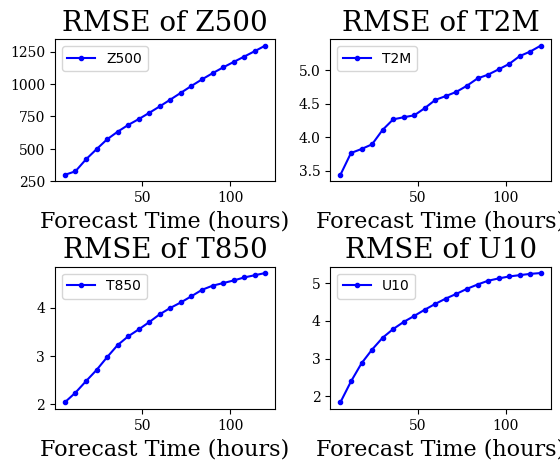

<Figure size 1400x700 with 0 Axes>

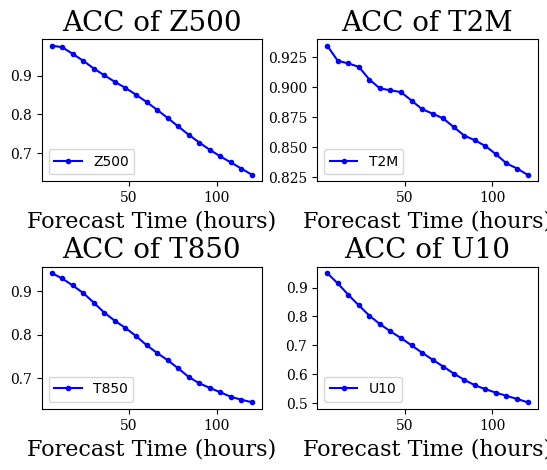

In [7]:
trainer.train()

## 模型推理及可视化

完成训练后，我们使用第100个ckpt进行推理。

In [ ]:
params = load_checkpoint('./summary/ckpt/step_1/koopman_vit-100_404.ckpt')
load_param_into_net(model, params)
class FourCastNetInferenceModule(InferenceModule):
    def forecast(self, inputs):
        pred_lst = []
        for _ in range(self.t_out):
            pred, _ = self.model(inputs)
            pred_lst.append(pred)
            inputs = pred
        return pred_lst
inference_module = FourCastNetInferenceModule(model, config, logger)

1


In [10]:
def plt_data(pred, label, root_dir, index=0):
    """ Visualize the forecast results """
    std = np.load(os.path.join(root_dir, 'statistic/std.npy'))
    mean = np.load(os.path.join(root_dir, 'statistic/mean.npy'))
    std_s = np.load(os.path.join(root_dir, 'statistic/std_s.npy'))
    mean_s = np.load(os.path.join(root_dir, 'statistic/mean_s.npy'))

    plt.figure(num='e_imshow', figsize=(100, 50), dpi=50)

    plt.subplot(4, 3, 1)
    plt_global_field_data(label, 'Z500', std, mean, 'Ground Truth')  # Z500
    plt.subplot(4, 3, 2)
    plt_global_field_data(pred, 'Z500', std, mean, 'Pred')  # Z500
    plt.subplot(4, 3, 3)
    plt_global_field_data(label - pred, 'Z500', std, mean, 'Error')  # Z500

    plt.subplot(4, 3, 4)
    plt_global_field_data(label, 'T850', std, mean, 'Ground Truth')  # T850
    plt.subplot(4, 3, 5)
    plt_global_field_data(pred, 'T850', std, mean, 'Pred')  # T850
    plt.subplot(4, 3, 6)
    plt_global_field_data(label - pred, 'T850', std, mean, 'Error')  # T850

    plt.subplot(4, 3, 7)
    plt_global_field_data(label, 'U10', std_s, mean_s, 'Ground Truth', is_surface=True)  # U10
    plt.subplot(4, 3, 8)
    plt_global_field_data(pred, 'U10', std_s, mean_s, 'Pred', is_surface=True)  # U10
    plt.subplot(4, 3, 9)
    plt_global_field_data(label - pred, 'U10', std_s, mean_s, 'Error', is_surface=True)  # U10

    plt.subplot(4, 3, 10)
    plt_global_field_data(label, 'T2M', std_s, mean_s, 'Ground Truth', is_surface=True)  # T2M
    plt.subplot(4, 3, 11)
    plt_global_field_data(pred, 'T2M', std_s, mean_s, 'Pred', is_surface=True)  # T2M
    plt.subplot(4, 3, 12)
    plt_global_field_data(label - pred, 'T2M', std_s, mean_s, 'Error', is_surface=True)  # T2M

    plt.savefig(f'pred_result.png', bbox_inches='tight')
    plt.show()

In [ ]:
test_dataset_generator = ViTKNOEra5Data(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=config["data"]['num_workers'], shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']
pred_time_index = 0
pred = inference_module.forecast(inputs)
pred = pred[pred_time_index]
ground_truth = labels[..., pred_time_index, :, :].asnumpy()
plt_data(pred.asnumpy(), ground_truth, config['data']['root_dir'])

inputs.shape (1, 69, 128, 256)
labels.shape (1, 69, 20, 128, 256)
1111
pred111.shape (1, 69, 128, 256)
pred.shape (1, 69, 128, 256)
ground_truth.shape (1, 69, 128, 256)


1


下述展示了第100个ckpt的真实值、预测值和他们之间的误差可视化。

![plot result](./images/pred_result.png)